**MPL**

Евгений Борисов <esborisov@sevsu.ru>

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [4]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=10_000, n_features=2, centers=2, cluster_std=[1.7,1.8] )
# X,target = make_blobs( n_samples=100_000, n_features=1024, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(10000, 3) (10000,)


In [5]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

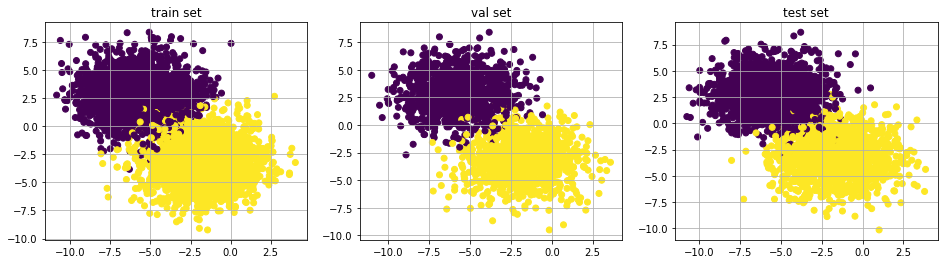

In [6]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [7]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## MPL

In [8]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}
# y_train, y_val, y_test = [ (y*2)-1 for y in [ y_train, y_val, y_test ] ]

y_train.shape,y_val.shape,y_test.shape

((4489, 2), (2211, 2), (3300, 2))

In [ ]:
class Layer:
    
    def forward(self,x): pass
    
    def backward(self,y): pass

In [ ]:
class Transformation(Layer):
        
    def _transform(self,x): pass

    def _derivative(self,x): pass
                
    def forward(self,x): 
        return self._transform(x)
    
    def backward(self,y): return y

    
class LinearActivation(Transformation):
    
    def _transform(self,x): return x
    
    def _derivative(self,x): return x
    
    
class SigmoidActivation(Transformation):
              
    def _transform(self,s):
        return 1./(1.+np.exp(-s) )
    
    def _derivative(self,s):
        o = cls.transform(s)
        return o*(1.-o)

In [ ]:
class DenseLayer(Layer):
    
    def __init__(self,initiator):
        self._weight = initiator.get()
    
    def forward(self,x): 
        return x.dot(self._weight)
    
    def backward(self,y):
        return y.dot(self._weight.T)

In [16]:
class Model:
    
    def __init__(self,layers): 
        self._layers = layers
        
    def score(self,x): pass
    
    def _partial(self,x): pass
    
    
class Sequental(Model):
    
    def _score(self,x):   
        o = x
        for l in self._layers:
            o = l.forward(o)
        return o

    def score(self,x):   
        return self._score(x)   
    
    def _partial(self,x): pass
    
    def _layers_out(self,x):
        o = [ x ]
        for l in self._layers:
            o.append( l.forward(o) )
        return o
    
        o = [x]
        for i,w in enumerate(self._weight):
            o.append( self._activation[i].transform( o[-1].dot(w) ) )
        return o
    
    def _layers_derivative(self,x):
        o = [x]
        for i,w in enumerate(self._weight):
            o.append( self._activation[i].derivative(o[-1].dot(w)) )
        return o
    
#     def _partial(self,x):
#         return [ s*d for s,d in zip( self._layers(x), self._score_derivative(x) ) ]
    
#     def _back(self,d): 
#         o = [d]
#         for w in self._weight[1:][::-1]:
#             o.append(o[-1].dot(w.T))
#         return o[::-1]    
    
    

In [19]:
from lib.initiator.linear import NormalInitiatorLinearModel

model = Sequental([
    DenseLayer( NormalInitiatorLinearModel(input_size=X_train.shape[1], output_size=10,scale=.001,) ),
    SigmoidActivation(),
    DenseLayer( NormalInitiatorLinearModel(input_size=10, output_size=2,scale=.001,) ),
    LinearActivation(),
])

model.score(X_train).shape

(4489, 2)

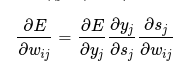

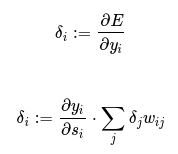

In [ ]:
from lib.loss.base import Loss

class MSQE_BP(Loss):
       
    def _estimate(self,output,target): 
        assert (output.shape==target.shape),f'incompatible shape output {output.shape} and target {target.shape}'
        d = (output-target).flatten()
        return d.dot(d.T)/len(output)    
    
    def _norm(self,grad):
        if not self._normalize_gradient: return grad
        amax = max([ np.abs(g).max() for g in grad ])
        return grad if amax==0. else [ g/amax for g in grad ]
    
    def _gradient(self,input_data,target): 
        d = (self._model.score(input_data) - target)
        back = self._model._back(d)
        partial = self._model._partial(input_data)
        grad = [ p.T.dot(b)/len(p) for b,p in zip(back,partial[:-1]) ]
        return self._norm(grad)

In [ ]:
# from lib.model.mlp import MLP
from lib.initiator.linear import NormalInitiatorLinearModel

model = MLP(
    initiator=[
        [ NormalInitiatorLinearModel(input_size=X_train.shape[1], output_size=10,scale=.001,),BiSigmoid() ],
        [ NormalInitiatorLinearModel(input_size=10, output_size=y_train.shape[1],scale=.001,),BiSigmoid() ],
    ],)


# model.weight
# model._activation
# model.predict(X_test)
# [ s.shape for s in model._state(X_test) ] 
# [ d.shape for d in model._score_derivative(X_test) ]

# partial = model._partial(X_test)
# back = model._back(y_test)

# [ p.shape for p in partial ]
# [ b.shape for b in back ]
# [ l.shape for l in model._layers(X_test) ]

# grad = [ p.T.dot(b)/len(p) for b,p in zip(back,partial[:-1]) ]

# [ g.shape for g in grad ]

# grad


In [ ]:
loss_train = MSQE_BP(model)

# loss.estimate(X_train,y_train)
# loss.gradient(X_train,y_train)

In [ ]:
from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = GD(
    loss=loss_train,
    # loss_val=loss_val,
    lra=ConstLRA(.009),
    # breaker_val=[GrowthBreaking(),]
    breaker=[GrowthBreaking(),]
    
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

In [ ]:
# not(len(breaker_val)>0) or (loss_val is None)

# 1, True



In [ ]:
# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

In [ ]:
# class Activation:
    
#     @staticmethod
#     def transform(s): pass 
    
#     @staticmethod
#     def derivative(s): pass 
    
    

# class BiSigmoid(Activation):
    
#     @staticmethod
#     def transform(s): return np.tanh(s) 
    
#     @staticmethod
#     def derivative(s): return 1./np.square(np.cosh(s))

    
    
# class Sigmoid(Activation):
    
#     @staticmethod
#     def transform(s): 
#         return 1./(1.+np.exp(-s) )
    
#     @classmethod
#     def derivative(cls,s): 
#         o = cls.transform(s)
#         return o*(1.-o)

    
    
# class Softmax(Activation):
    
#     @staticmethod
#     def transform(s): 
#         assert s.shape[1]>1,'incorrect activation argument size'
#         es = np.exp(s)
#         ess = es.sum(axis=1)[:,np.newaxis]
#         with np.errstate(invalid='ignore',divide='ignore'):
#             o = np.where( ess!=0., es/ess, 0. )
#         return o
    
#     @classmethod
#     def derivative(cls,s): 
#         o = cls.transform(s)
#         return o*(1.-o) 
        
    

In [ ]:
# class Weight:
    
#     def __init__(self,data=[]):
#         self._data = data
   
#     def __add__(self,other):
#         return [ d+other for d in data ]
    
#     def __mul__(self,other):
#         return [ d*other for d in data ]

#     def __div__(self,other):
#         return [ d/other for d in data ]
    
#     def __sub__(self,other):
#         return [ d-other for d in data ]
    
#     def sqrt(self):
#         with np.errstate(invalid='ignore',divide='ignore'):
#             d = [ np.where( d>0., np.sqrt(d), 0. ) for d in data ]
#         return d

In [ ]:
# from lib.model.base import MLModel

# class MLP(MLModel): 

#     def __init__(self,initiator):
#         self._activation = []
#         super().__init__(initiator) # инициализируем параметры с помощью процедуры initiator

#     def _reset(self): # процедура инициализации генерирует начальные веса модели
#         self._weight = Weight([ i[0].get() for i in self._initiator ])
#         self._activation = [ i[1] for i in self._initiator ]
#         return self    
        
#     def _score(self,x): # генерируем выход модели
#         o = x
#         for i,w in enumerate(self._weight):
#             o = self._activation[i].transform(o.dot(w))
#         return o

# #     def _state(self,x):
# #         o,s = x, []
# #         for i,w in enumerate(self._weight):
# #             s.append( o.dot(w) )
# #             o = self._activation[i].transform(s[-1])
# #         return s
    
#     def _layers(self,x):
#         o = [x]
#         for i,w in enumerate(self._weight):
#             o.append( self._activation[i].transform( o[-1].dot(w) ) )
#         return o
    
#     def _score_derivative(self,x):
#         o = [x]
#         for i,w in enumerate(self._weight):
#             o.append( self._activation[i].derivative(o[-1].dot(w)) )
#         return o
    
#     def _partial(self,x):
#         return [ s*d for s,d in zip( self._layers(x), self._score_derivative(x) ) ]
    
#     def _back(self,d): 
#         o = [d]
#         for w in self._weight[1:][::-1]:
#             o.append(o[-1].dot(w.T))
#         return o[::-1]
